In [1]:
from bs4 import BeautifulSoup
import requests
import re
import pprint
import wordfreq
import matplotlib.pyplot as plt
import numpy as np
import statsmodels.api as sm
import pandas as pd
import random
import datetime
from sklearn.cluster import SpectralClustering

/anaconda3/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


These functions are meant to extract presidential speeches from the site millercenter.org.  get_president(N) finds the Nth president and returns a "speeches" variable that is a list containing the text of each speech by that president.  The president's number is 1-indexed, so George Washington is president number 0, while Donald Trump is president number 43.  Grover Cleveland is only counted once, as president number 21, although he was elected twice to nonconsecutive term.  This convention is followed throughout.

In [2]:
# The 0th president (Washington) is actually numbered 44 on millercenter.org.  Thus, we have to convert
# the president's number 0 through 43 into a number suitable for millercenter.org.  Trump is, randomly enough
# president number 8396.
# The 21st and 23rd president would ordinarily both be Cleveland, but Cleveland is only counted once.
# #23 is considered to be Harrison; that means there are only 44 presidents
def pres_numbers_list():
    return [44, 45] + [3, 4] + [141] + list(range(6, 44)) + [8396]

def get_pres_name(N):
    return ["George Washington", "John Adams", "Thomas Jefferson", "James Madison", "James Monroe", "John Quincy Adams",\
           "Andrew Jackson", "Martin van Buren", "William Harrison", "John Tyler", "James K. Polk", "Zachary Taylor",\
           "Millard Fillmore", "Franklin Pierce", "James Buchanan", "Abraham Lincoln", "Andrew Johnson",\
           "Ulysses S. Grant", "Rutherford B. Hayes", "James A. Garfield", "Chester A. Arthur", "Grover Cleveland",\
           "Benjamin Harrison", "William McKinley", "Theodore Roosevelt", "William Taft", "Woodrow Wilson",\
           "Warren G. Harding", "Calvin Coolidge", "Herbert Hoover", "Franklin D. Roosevelt", "Harry S. Truman",\
           "Dwight D. Eisenhower", "John F. Kennedy", "Lyndon B. Johnson", "Richard Nixon", "Gerald Ford",\
           "Jimmy Carter", "Ronald Reagan", "George H. W. Bush", "Bill Clinton", "George W. Bush", "Barack Obama",\
           "Donald Trump"][N]

def get_president(N):
    if N < 0 or N > 43:
        print("Error: no president", N)
        return list()
    N = pres_numbers_list()[N]
    millerpage = f"https://millercenter.org/the-presidency/presidential-speeches?field_president_target_id[{N}]={N}"
    page = requests.get(millerpage)
    soup = BeautifulSoup(page.content, 'html.parser')
    #dummy = 'a href="/the-presidency/presidential-speeches'
    speechlist = soup.find_all(href=re.compile('/the-presidency/presidential-speeches/'))
    URLlist = ["https://millercenter.org" + x['href'] for x in speechlist]
    #pprint.pprint(URLlist)
    speeches = list()
    n = -1
    for URL in URLlist:
        n = n + 1
        page = requests.get(URL)
        soup = BeautifulSoup(page.content, 'html.parser')
        for e in soup.find_all('br'):
            e.replace_with('\n')
        x = soup('h3', text="Transcript")
        listofps = x[0].parent.findChildren('p')
        #print([type(p.contents[0]) for p in listofps])
        #string = string.replace(u'\xa0', u' ')
        # print([p.contents[0].name for p in listofps])
        textofspeech = " ".join([" ".join([c for c in p.contents if not c.name]) for p in listofps])
        # Replace funny single quote #8217 with single quote #39
        textofspeech = textofspeech.replace('\’', "'")
        textofspeech = textofspeech.replace("\'", "'")
        speeches.append(textofspeech)
    return speeches


get_overrep_words takes a list of the text of each speech, and returns a dictionary of "overrepresented words" the form:

d[word] = weight

The "weight" for each word is calculated as follows.  The goal is to have a weight that reflects (1) the relative incidence of the word in the speech corpus compared with its usual incidence in the English language, (2) the overall incidence of the word in the speech corpus.  Thus, a word that is highly unusual ("supercalifragilisticexpealidocious") but only appears once in the speech corpus is not that interesting.  In contrast, a word that is very common, but appears only the usual amount in the corpus ("the") is also not interesting.  The weight for each words is computed as a product of these two factors.

Getting into the details: To compute the weight, the incidence count of the word is first tallied in the combined speeches of a president.
Using the wordfreq library, each word's frequency in English is obtained (actually the log of the frequency), so that it can be compared with the log of the frequency in the speeches.
Using the statsmodels library, a least squares regression is used to find the linear relationship between these two logs.

This linear relationship can then be used to compute the predicted English frequency for a word that has the given corpus frequency.  This predicted English frequency can be compared to the word's actual English frequency.  The difference between predicted and actual (using subtraction) is essentially a measure of how much more common the word is in the speech corpus compared to the English language.  A weight value of 1 would mean that the word is "e" times more common in the speech corpus as compared with English.

Next, the number of words in each set of speeches can range from 20,000 to 800,000, so the number of appearances is multiplied by (800,000 / length) to get the number that would appear in 800,000.  Then, the log is taken.  This number is multiplied by the weight to get the final weight value.  This takes into account that we care more about words that appear many times as opposed to only once.

In [25]:
def get_overrep_words(speeches, makeplot = False):
    speeches_combined = " ".join(speeches)
    print("Length of speeches:", len(speeches_combined))
    wordlist = wordfreq.tokenize(speeches_combined, 'en')
    length = len(wordlist)
    freqlist = [(x, wordlist.count(x)) for x in set(wordlist)]
    freqlist.sort(key = lambda x: x[1])
    freqmap = [(np.log(wordfreq.word_frequency(x[0], 'en')), np.log(x[1] / length)) for x in freqlist]
    xy = list(zip(*freqmap))
    #plt.figure()
    #plt.plot(*xy, 'b.')
    dfxy = pd.DataFrame(xy).T
    dfxy.columns = ['logen', 'logcorpus']
    dfxy = dfxy.replace([np.inf, -np.inf], np.nan).dropna()
    #print(dfxy)
    if makeplot:
        dfxy.plot(x='logcorpus', y='logen', title = 'log-log plot to predict English frequency')
        plt.xlabel('log of corpus frequency')
        plt.ylabel('log of English frequency')
        plt.gcf().savefig("logen_plot.png")
    model = sm.OLS.from_formula('logen ~ logcorpus', dfxy) 
    regr = model.fit()
    #regr.summary()

    # Replace funny single quote #8217 with single quote #39
    freqlist = [(x[0].replace('’', "'"), x[1]) for x in freqlist]
    
    # An item in this list is: (word, weight, corpus frequency)
    weightlist = [(x[0], (regr.predict(pd.Series([np.log(x[1] / length)], name='logcorpus')).iloc[0] - \
            np.log(wordfreq.word_frequency(x[0], 'en'))) + np.log(x[1] * 800000 / length), \
            np.log(x[1] / length)
            ) for x in freqlist if ((x[1] * 800000 / length > 1) and x[0] != 'applause' and x[0] != 'laughter' and x[0] != 'booo')]
    
    if makeplot:
        plt.figure()
        plt.plot([x[2] for x in weightlist], [x[1] for x in weightlist], 'k-')
        plt.title('weight vs. log corpus frequency')
        plt.xlabel('log of corpus frequency')
        plt.ylabel('assigned weight')
        plt.gcf().savefig("weight_plot.png")
        
    return {x[0]: x[1] for x in weightlist if (x[1] > 1 and not np.isinf(x[1]))}

James K. Polk
Length of speeches: 49777


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:8: RuntimeWarning: divide by zero encountered in log
  
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in log


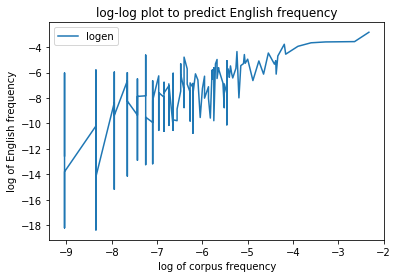

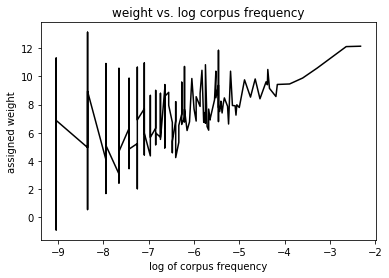

In [27]:
print(get_pres_name(10))
_ = get_overrep_words(get_president(8), makeplot = True)

In [28]:
def make_two_speech_lists(speeches):
    lst1 = np.random.choice(speeches, size=int(len(speeches)/2), replace=False)
    lst2 = [x for x in speeches if not (x in lst1)]
    return (lst1, lst2)

get_paired_words returns a list of the form:

[(word1, sim1), (word2, sim2), ...]

Where the similarity score (sim1) for word 1 is the minimum of the word's weight for president M and for president N.  Only words that appear in both president M and president N's speeches will get a score.

get_similarity finds the total similarity score by adding them up.

The result is a similarity score that compares the two presidents.  If the presidents share more words in common (and with higher weights), then their similarity score will tend to be higher.

In [29]:
def get_paired_words(overrep_words, M, N):
    if M < 0 or M >= len(overrep_words) or N < 0 or N >= len(overrep_words):
        print("M or N is out of bounds in get_paired_words.")
        return list()
    paired_words = list()
    for x in overrep_words[M]:
        if x in overrep_words[N]:
            paired_words.append((x, min(overrep_words[M][x],overrep_words[N][x])))
    return paired_words

def get_similarity(overrep_words, M, N):
    pw = get_paired_words(overrep_words, M, N)
    total = sum(x[1] for x in pw)
    return total

This code block loops through a range of presidents, getting a list of overrepresented words (with their weights) and a list of frequencies for each.

In [41]:
NUMP = 44

train_test = True

random.seed(datetime.datetime.now())

def generate_overrep_words(NUMP):

    overrep_words = list()
    overrep_words_test = list()

    for N in range(44 - NUMP, 44):
        print(get_pres_name(N))
        speeches = get_president(N)
        sp_train, sp_test = make_two_speech_lists(speeches)
        if train_test:
            if len(sp_train) == 0:
                sp_train = sp_test.copy()
                print("Only one (testing) speech for president ", N)
            if len(sp_test) == 0:
                sp_test = sp_train.copy()
                print("Only one (training) speech for president ", N)
            ov = get_overrep_words(sp_train)
            ov_test = get_overrep_words(sp_test)
            overrep_words.append(ov)
            overrep_words_test.append(ov_test)
        else:
            ov = get_overrep_words(speeches)
            overrep_words.append(ov)
            
    return overrep_words, overrep_words_test
    
overrep_words, overrep_words_test = generate_overrep_words(NUMP)

George Washington
Length of speeches: 85044


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:8: RuntimeWarning: divide by zero encountered in log
  
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in log


Length of speeches: 43598
John Adams
Length of speeches: 30117
Length of speeches: 58792
Thomas Jefferson
Length of speeches: 58007
Length of speeches: 58610
James Madison
Length of speeches: 75029
Length of speeches: 61794
James Monroe
Length of speeches: 128993
Length of speeches: 168228
John Quincy Adams
Length of speeches: 99106
Length of speeches: 122767
Andrew Jackson
Length of speeches: 276267
Length of speeches: 231983
Martin van Buren
Length of speeches: 211944
Length of speeches: 179254
William Harrison
Only one (testing) speech for president  8
Length of speeches: 49777
Length of speeches: 49777
John Tyler
Length of speeches: 182815
Length of speeches: 94055
James K. Polk
Length of speeches: 60330
Length of speeches: 265161
Zachary Taylor
Length of speeches: 16644
Length of speeches: 51909
Millard Fillmore
Length of speeches: 142752
Length of speeches: 92502
Franklin Pierce
Length of speeches: 123093
Length of speeches: 183348
James Buchanan
Length of speeches: 236173
Length

Create a similarity matrix such that X[i,j] is the similarity of presidents i and j.  Then, print the cluster labels and cluster centers.  Then use SpectralClustering to perform the clustering.

In [43]:
def similarity_matrix(overrep_words):
    X = np.zeros((NUMP, NUMP))
    for i in range(0, NUMP):
        for j in range(0, i):
            X[i,j] = get_similarity(overrep_words, i, j)
            X[j,i] = X[i,j]
    return X

n_clusters = 3

X = similarity_matrix(overrep_words)
#clustering = AgglomerativeClustering(n_clusters=n_clusters, affinity="precomputed", linkage="average").fit(X)
clustering = SpectralClustering(n_clusters=n_clusters, affinity="precomputed", assign_labels="discretize").fit(X)
print("Labels:", clustering.labels_)
#print("Centers:", clustering.cluster_centers_)

if train_test:
    X_test = similarity_matrix(overrep_words_test)
    #clustering_test = AgglomerativeClustering(n_clusters=n_clusters, affinity="precomputed", linkage="average").fit(X_test)    
    clustering_test = SpectralClustering(n_clusters=n_clusters, affinity="precomputed", assign_labels="discretize").fit(X_test)
    print("Labels test:", clustering_test.labels_)

Labels: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 2 2 0 2 2 2 2 2 2 1 2 2 2 1 1 1 1 1 1 1
 1 1 1 1 1 1 1]
Labels test: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 0 1 1 1 1 1 1 1 2 1 1 2 2 2 2 2 2 2
 2 2 2 2 2 2 2]


compute_cluster_overlap will compute the overlap between the training and testing data.  The overlap is defined by assuming that each cluster in the training data corresponds to the cluster(s) in the testing data with the best fit (the maximum overlap.)  Then, the number of presidents whose training cluster matches their testing cluster is counted.

In [44]:
def compute_cluster_overlap(labels1, labels2):
    if len(labels1) != len(labels2):
        print("Error in compute_cluster_overlap: labels1, labels2 not same length.")
        return
    corresp = dict()
    for lab1 in set(labels1):
        ct = dict()
        for lab2 in set(labels2):
            for i in range(len(labels1)):
                ct.setdefault(lab2, 0)
                if labels1[i] == lab1 and labels2[i] == lab2:
                    ct[lab2] += 1
        ctreverse={v:k for k,v in ct.items()}
        corresp[lab1] = ctreverse[max(ctreverse)]
    total = 0
    for i in range(len(labels1)):
        if labels2[i] == corresp[labels1[i]]:
            total += 1
    print("Correspondence (training cluster: testing cluster):", corresp)
    print("Overlap ratio:", total, "out of", len(labels1))        
    return total, len(labels1)

compute_cluster_overlap(clustering.labels_, clustering_test.labels_)

Correspondence (training cluster: testing cluster): {0: 0, 1: 2, 2: 1}
Overlap ratio: 40 out of 44


(40, 44)

These functions make use of only the training set data (or all of the data, if you have set train_test = False).

get_inlist will make a list of the numbers of the president that belong to the ith cluster in the training set (zero indexed this time.)

get_characteristic_words accepts as an argument a list of president numbers (zero indexed this time.)  Thus, a list [0, 2, 3] will combine the 0th, 2nd, and 3rd presidents into a group, which is then compared with all presidents not in the list.  You can use get_inlist to generate this list from a cluster number, or you can pick a single president with a single element list like [2].

The function finds the median weight in the "inlist" and the median weight in the "outlist," subtracting the two to find the score for each word.  In the resulting list, a positive score indicates that a word has a high weight in the inlist, while a negative score indicates that it has a high weight in the outlist.  If there are an odd number of presidents in the list, the median takes the lower of the two middle numbers.

Thus, to find the most characteristic words in the inlist, scroll to the end of the output and look at the words with the highest score

In [45]:
import statistics

def medlow(lst):
    sortlst = sorted(lst)
    if len(sortlst) % 2 == 0:
        return(sortlst[int(len(sortlst) / 2) - 1])
    else:
        return(sortlst[int(len(sortlst) / 2 - 0.5)])

def get_inlist(lab, i):
    return [j for j in range(0, len(lab)) if lab[j] == i]
    
def get_characteristic_words(overrep_words, inlist):
    wordscore_in = dict()
    wordscore_out = dict()
    for k in range(0, len(overrep_words)):
        if k in inlist:
            for word, score in overrep_words[k].items():
                wordscore_in.setdefault(word, list())
                wordscore_in[word].append(score)
        else:
            for word, score in overrep_words[k].items():
                wordscore_out.setdefault(word, list())
                wordscore_out[word].append(score)
    for word in wordscore_in.keys():
        for i in range(0, len(inlist) - len(wordscore_in[word])):
            wordscore_in[word].append(0)
    for word in wordscore_out.keys():
        for i in range(0, (len(overrep_words) - len(inlist)) - len(wordscore_out[word])):
            wordscore_out[word].append(0)
    scorelist = list()
    for word in wordscore_in.keys():
        med_in = medlow(wordscore_in[word]) if word in wordscore_in.keys() else 0
        med_out = medlow(wordscore_out[word]) if word in wordscore_out.keys() else 0
        scorelist.append((word, med_in - med_out))
    return sorted(scorelist, key = lambda x: x[1])

print([x[0] for x in get_characteristic_words(overrep_words, get_inlist(clustering.labels_, 0))[-50:]])

['afforded', 'sentiments', 'vested', 'thereof', 'enlightened', 'negotiation', 'deemed', 'objects', 'forbearance', 'expedient', 'guaranty', 'render', 'territories', 'ascertained', 'sanction', 'contemplated', 'depredations', 'doubtless', 'ports', 'entertained', 'amicable', 'object', 'honorable', 'harbors', 'vessels', 'commencement', 'hereafter', 'labors', 'exertions', 'pecuniary', 'communicated', 'favorable', 'hitherto', 'satisfactory', 'blessings', 'approbation', 'execution', 'earnestly', 'plenipotentiary', 'receipts', 'tribes', 'tranquillity', 'effectual', 'justly', 'effectually', 'pursuance', 'continuance', 'intercourse', 'herewith', 'heretofore']


In [46]:
print([x[0] for x in get_characteristic_words(overrep_words, get_inlist(clustering.labels_, 1))[-50:]])

["world's", 'going', 'middle', 'democratic', 'chance', 'problems', 'lives', 'world', 'million', 'threat', 'succeed', 'adversaries', 'east', 'hopes', 'achieve', 'presidency', 'stand', 'program', 'ahead', 'courage', 'ago', 'asia', 'america', 'resolve', 'leadership', 'proud', 'jobs', 'reform', 'bipartisan', 'want', 'cannot', 'help', 'budget', 'democracy', 'weapons', 'economic', 'commitment', 'tax', 'agreements', 'know', 'percent', 'leaders', 'nuclear', 'tonight', 'soviet', 'today', "nation's", 'allies', 'americans', "america's"]


In [47]:
print([x[0] for x in get_characteristic_words(overrep_words, get_inlist(clustering.labels_, 2))[-50:]])

['localities', 'beneficent', 'especial', 'offices', 'enacted', 'requisite', 'liberality', 'indemnity', 'intercourse', 'surplus', 'cent', 'methods', 'postmasters', 'practicable', 'securing', 'currency', 'pursuance', 'vessels', 'canal', 'bonds', 'legation', 'railroads', 'expended', 'cruisers', 'authorizing', 'nicaragua', 'recommendation', 'earnest', 'statute', 'commend', 'armament', 'postal', 'arbitration', 'herewith', 'disposition', 'pending', 'receipts', 'guaranty', 'furnish', 'effectually', 'enactment', 'postmaster', 'speedily', 'gratifying', 'evils', 'intrusted', 'appropriation', 'heretofore', 'tariff', 'earnestly']


In [48]:
print([x[0] for x in get_characteristic_words(overrep_words, [43])[-50:]]) # Trump

['cheerleader', 'raqqa', 'allies', "cj's", 'incredible', 'tonight', 'isis', 'celestino', 'cuevas', "we've", 'melania', 'surest', 'trump', 'strivers', 'terrorists', 'modernizes', 'trillion', 'denuclearization', 'gorsuch', 'autoworkers', 'thank', 'hardworking', "we're", '2,000k', "america's", 'businessperson', 'immigration', 'mattis', 'sempra', 'tremendous', 'ashlee', 'zinke', 'leppert', 'vetting', 'sequester', "otto's", 'orrin', "megan's", 'kenton', 'seong', 'scalise', 'staub', 'dreamers', 'mickens', 'schwab', 'goodlatte', 'daca', 'cornyn', 'jamiel', 'anwr']


In [49]:
print([x[0] for x in get_characteristic_words(overrep_words, [42])[-50:]]) # Obama

['workers', 'wages', "rebekah's", 'strivers', 'barkeeper', 'middle', 'begrudged', 'rutt', 'erler', 'wage', 'republicans', "that's", '401ks', 'antidiscrimination', 'scrimped', 'americans', 'loopholes', 'insourcing', 'aristocracies', 'deficits', 'unclogging', 'budged', 'folks', "america's", "medicare's", 'demars', "we're", "barack's", 'diplomacy', 'hardworking', 'galesburg', 'reenergized', "we've", 'childcare', 'remsburg', 'bipartisan', 'businesses', 'rebekah', 'autoworker', 'neera', 'bedrolls', 'jobs', 'assad', 'likelier', "assad's", 'inequality', 'selma', 'warrensburg', 'ucm', 'jennies']
